In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pycbc
import os, time
from IPython.display import display, clear_output

In [2]:
sample_rate = 4096
duration = 6.
dt=1./sample_rate

f0 = 40.
f_low = 40.
f_high =  2048.
df = 1.
m1_min = 1.
m1_max = 99.
m2_min = m1_min
m2_max = m1_max
max_total_m = 100.
max_spin = 0.99

min_match = 0.97
filter_cutoff = 'SchwarzISCO'
psd_model = 'aLIGODesignSensitivityP1200087'

outfile='template_bank.xml'
template_file='templates'
signal_file='signal'
noise_file='noise'

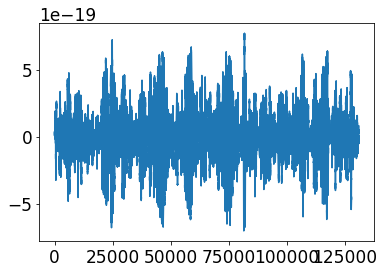

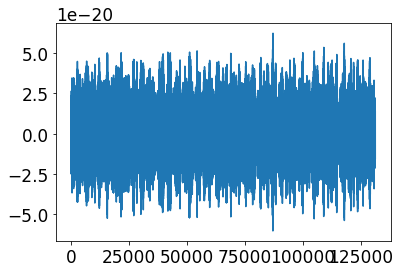

In [3]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW150914")
strain = merger.strain('H1')
plt.plot(strain)
plt.show()
strain = resample_to_delta_t(highpass(strain, f_low), dt)
#plt.plot(strain[75000:100000])
plt.plot(strain)
plt.show()

In [4]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
conditioned = strain.crop(8, 8)
noise = strain.crop(16, 0)
psd = conditioned.psd(1)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(sample_rate),
                                  low_frequency_cutoff=f_low)
print(len(conditioned))
print(len(noise))

65536
65536


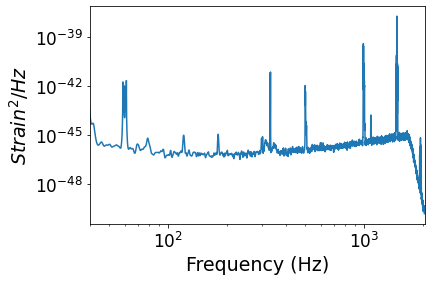

In [5]:
plt.loglog(psd.sample_frequencies, psd)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.xlim(f_low, f_high)
plt.show()

In [6]:
!echo "pycbc_geom_aligned_bank --pn-order twoPN --f0 {f0} --f-low {f_low} --f-upper {f_high} --delta-f {df} --min-match {min_match} --min-mass1 {m1_min} --min-mass2 {m2_min} --max-mass1 {m1_max} --max-mass2 {m2_max} --verbose --output-file {outfile} --calculate-ethinca-metric --filter-cutoff {filter_cutoff} --psd-model {psd_model} --max-total-mass {max_total_m} --max-bh-spin-mag {max_spin}"

pycbc_geom_aligned_bank --pn-order twoPN --f0 40.0 --f-low 40.0 --f-upper 2048.0 --delta-f 1.0 --min-match 0.97 --min-mass1 1.0 --min-mass2 1.0 --max-mass1 99.0 --max-mass2 99.0 --verbose --output-file template_bank.xml --calculate-ethinca-metric --filter-cutoff SchwarzISCO --psd-model aLIGODesignSensitivityP1200087 --max-total-mass 100.0 --max-bh-spin-mag 0.99


In [7]:
if not os.path.isfile(outfile):
    !echo "pycbc_geom_aligned_bank --pn-order twoPN --f0 {f0} --f-low {f_low} --f-upper {f_high} --delta-f {df} --min-match {min_match} --min-mass1 {m1_min} --min-mass2 {m2_min} --max-mass1 {m1_max} --max-mass2 {m2_max} --verbose --output-file {outfile} --calculate-ethinca-metric --filter-cutoff {filter_cutoff} --psd-model {psd_model} --max-total-mass {max_total_m} --max-bh-spin-mag {max_spin}"
    !pycbc_geom_aligned_bank --pn-order twoPN --f0 {f0} --f-low {f_low} --f-upper {f_high} --delta-f {df} --min-match {min_match} --min-mass1 {m1_min} --min-mass2 {m2_min} --max-mass1 {m1_max} --max-mass2 {m2_max} --verbose --output-file {outfile} --calculate-ethinca-metric --filter-cutoff {filter_cutoff} --psd-model {psd_model} --max-total-mass {max_total_m} --max-bh-spin-mag {max_spin}

In [8]:
datafreq = np.fft.fftfreq(len(conditioned))*sample_rate
psd_ = np.interp(datafreq, np.array(psd.sample_frequencies), np.array(psd))
np.save('psd',psd_)

In [9]:
from pycbc.waveform.bank import TemplateBank

waveforms = TemplateBank(outfile)

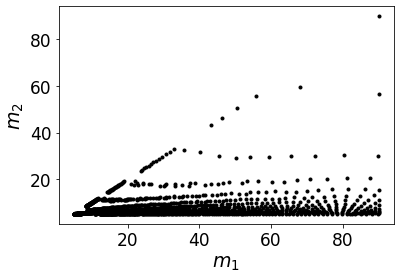

In [10]:
%matplotlib inline

plt.scatter(waveforms.table['mass1'],waveforms.table['mass2'],marker='.',color='black')
plt.xlabel(r'$m_{1}$')
plt.ylabel(r'$m_{2}$')
plt.show()

In [11]:
m1s = waveforms.table['mass1']
m2s = waveforms.table['mass2']
s1s = waveforms.table['spin1z']
s2s = waveforms.table['spin2z']

In [12]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import make_frequency_series
from pycbc.types import TimeSeries, FrequencySeries

templates = []
hps= []
hps_f= []


if True:
    
    M = int(2**(3))
    
    dm = (m1_max-m1_min)/np.floor(np.sqrt(2.*M))
    m1s = np.arange(m1_min,m1_max,dm)
    print(m1s)
    templates = []
    i=0
    for m1 in m1s:
        m2 = m1
        while m2<m1_max and i<M:
            #clear_output(wait=True)
            #display("Generated template "+str(i+1)+" of "+str(M)+"...")
            waveform = get_td_waveform(approximant="IMRPhenomPv3",
                                 mass1=float(m1),
                                 mass2=float(m2),
                                 spin1z=0.,
                                 spin2z=0.,
                                 delta_t=dt,
                                 f_lower=f_low)
            waveform[0].resize(len(conditioned))
            hps.append(waveform[0])
            hps_f.append(np.array(make_frequency_series(TimeSeries(waveform[0],delta_t=dt))))
            fhp = np.fft.fft(np.array(waveform[0]))
            sq = np.abs((fhp * fhp.conjugate() / psd_).sum())
            norm = 4. / np.sqrt(4. * np.abs(datafreq[1]-datafreq[0]) * sq)
            templates.append((fhp/psd_)*norm)
            i+=1
            m2+=dm
    templates = np.array(templates)
    np.save(template_file,templates)
    print('Done!')

if False:
    i=0
    for m1,m2,s1,s2 in zip(m1s,m2s,s1s,s2s):
        clear_output(wait=True)
        display("Generated template "+str(i+1)+" of "+str(len(m1s))+"...")
        waveform = get_td_waveform(approximant="SEOBNRv4_opt",
                                 mass1=float(m1),
                                 mass2=float(m2),
                                 spin1z=float(s1),
                                 spin2z=float(s2),
                                 delta_t=dt,
                                 f_lower=f_low)
        waveform[0].resize(len(conditioned))
        hps.append(waveform[0])
        fhp = np.fft.fft(np.array(waveform[0]))
        sq = np.abs((fhp * fhp.conjugate() / psd_).sum())
        norm = 4. / np.sqrt(4. * np.abs(datafreq[1]-datafreq[0]) * sq)
        templates.append((fhp/psd_)*norm)
        i+=1

    templates = np.array(templates)
    np.save(template_file,templates)
    print('Done!')

[ 1.  25.5 50.  74.5]
Done!


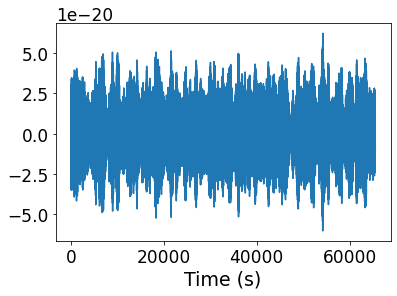

In [13]:
plt.plot(conditioned)
plt.xlabel('Time (s)')
plt.show()

In [14]:
def my_matched_filter(data, template):
    return data*template.conjugate()

In [15]:
signal = make_frequency_series(TimeSeries(np.array(conditioned), delta_t=dt))
noise = make_frequency_series(TimeSeries(np.array(noise), delta_t=dt))
np.save(signal_file,signal)
np.save(noise_file,noise)
df = np.abs(datafreq[1]-datafreq[0])
print(df)

0.0625


In [16]:
from pycbc.filter import matched_filter

SNRs = []
signal_f = np.array(signal)


for template,hp_f,hp in zip(templates,hps_f,hps):
    template_f = np.array(make_frequency_series(TimeSeries(hp, delta_t=dt)))
    snr_ = np.array(matched_filter(FrequencySeries(hp_f, delta_f=df), 
                                   FrequencySeries(signal_f, delta_f=df), 
                                   psd=FrequencySeries(psd_,delta_f=df)))
    print(np.max(np.abs(snr_)))
    SNRs.append(np.max(np.abs(snr_)))
SNRs = np.array(SNRs)
#print(SNRs)

38.79522458004389
4.650760823563481
6.888026975156672
8.883988729493396
12.475514225119689
18.577089086158633
16.460529484153447
16.68707726873623


In [17]:
from pycbc.filter import matched_filter

SNRs = []
signal_f = np.array(noise)
for template,hp_f,hp in zip(templates,hps_f,hps):
    template_f = np.array(make_frequency_series(TimeSeries(hp, delta_t=dt)))
    snr_ = np.array(matched_filter(FrequencySeries(hp_f, delta_f=df), 
                                   FrequencySeries(signal_f, delta_f=df), 
                                   psd=FrequencySeries(psd_,delta_f=df)))
    #print(hp_f)
    #print(np.max(np.abs(snr_)))
    #print(np.abs(snr_))
    #plt.plot(np.abs(snr_))
    #plt.show()
    SNRs.append(np.max(np.abs(snr_)))
SNRs = np.array(SNRs)
#print(SNRs)

In [18]:
SNR_threshold=18.

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1440 but corresponding boolean dimension is 8

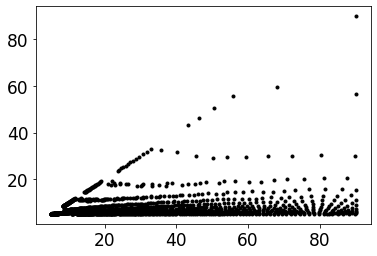

In [19]:
%matplotlib inline

plt.scatter(waveforms.table['mass1'],waveforms.table['mass2'],marker='.',color='black')
plt.scatter(waveforms.table['mass1'][SNRs>SNR_threshold],waveforms.table['mass2'][SNRs>SNR_threshold],marker='.',color='orange')

plt.xlabel(r'$m_{1}$')
plt.ylabel(r'$m_{2}$')
plt.show()

In [ ]:
max_ind = np.argmax(SNRs)
print(waveforms.table['mass1'][max_ind],waveforms.table['mass2'][max_ind])

In [ ]:
print(np.fft.ifft(templates[0]))
print(np.fft.ifft(templates[0]*psd_))

#for template in templates:
#    print(my_matched_filter(np.array(conditioned), np.fft.ifft(template)))
#    print(my_matched_filter(signal, template))
#    break

In [ ]:
print(np.mean(np.abs(np.real(np.fft.ifft(templates[0]*psd_)))))

In [ ]:
print(datafreq[1]-datafreq[0])

In [ ]:
print(m1s)